<a href="https://colab.research.google.com/github/ChacoGolden/DSML_EV/blob/main/swiss_cantons_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install geopandas matplotlib requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import json
import matplotlib.pyplot as plt

In [5]:
EV_share = pd.read_csv('https://raw.githubusercontent.com/ChacoGolden/DSML_EV/refs/heads/main/EV_share.csv')
EV_absolute = pd.read_csv('https://raw.githubusercontent.com/ChacoGolden/DSML_EV/refs/heads/main/EV_absolute.csv')
cars_number = pd.read_csv('https://raw.githubusercontent.com/ChacoGolden/DSML_EV/refs/heads/main/cars_number.csv')

In [7]:
# Load your uploaded canton GeoJSON file
gdf = gpd.read_file('/content/georef-switzerland-kanton.geojson')
print(gdf.columns)
print(gdf.head())

Index(['geo_point_2d', 'year', 'kan_area_code', 'kan_type', 'geometry'], dtype='object')
                                        geo_point_2d  year kan_area_code  \
0  { "lon": 9.0928704894966099, "lat": 47.5686744...  2023           CHE   
1  { "lon": 8.5917278345803698, "lat": 47.7135544...  2023           CHE   
2  { "lon": 8.7566661842000091, "lat": 47.0617774...  2023           CHE   
3  { "lon": 9.3686714568863803, "lat": 47.3661323...  2023           CHE   
4  { "lon": 7.7022030908944785, "lat": 47.4516883...  2023           CHE   

  kan_type                                           geometry  
0   Kanton  MULTIPOLYGON (((9.47843 47.49032, 9.48355 47.4...  
1   Kanton  MULTIPOLYGON (((8.56308 47.59945, 8.56187 47.5...  
2   Kanton  POLYGON ((8.57105 46.99016, 8.58242 46.99341, ...  
3   Kanton  POLYGON ((9.50292 47.34743, 9.50281 47.3478, 9...  
4   Kanton  MULTIPOLYGON (((7.32725 47.44005, 7.32733 47.4...  


In [8]:
latest_year = EV_share['date'].max()
ev_latest = EV_share[EV_share['date'] == latest_year].copy().iloc[0]
ev_share_dict = {col: float(ev_latest[col]) for col in EV_share.columns if col != 'date'}

In [9]:
with open('/content/georef-switzerland-kanton.geojson', 'r') as f:
    data = json.load(f)

# List all properties keys from the first feature
print(data['features'][0]['properties'].keys())
print(data['features'][0]['properties'])


dict_keys(['geo_point_2d', 'year', 'kan_code', 'kan_name', 'kan_area_code', 'kan_type'])
{'geo_point_2d': {'lon': 9.09287048949661, 'lat': 47.568674460332645}, 'year': '2023', 'kan_code': ['20'], 'kan_name': ['Thurgau'], 'kan_area_code': 'CHE', 'kan_type': 'Kanton'}


In [10]:
# Reload with geopandas to preserve geometry
gdf = gpd.read_file('/content/georef-switzerland-kanton.geojson')

# Extract 'kan_name' from the raw GeoJSON
import json
with open('/content/georef-switzerland-kanton.geojson', 'r') as f:
    data = json.load(f)

# Extract canton names
canton_names = [feature['properties']['kan_name'][0] for feature in data['features']]
gdf['kan_name'] = canton_names

# Preview
print(gdf[['kan_name']].head())

                 kan_name
0                 Thurgau
1            Schaffhausen
2                  Schwyz
3  Appenzell Ausserrhoden
4        Basel-Landschaft


In [11]:
canton_abbr = {
    'Aargau': 'AG', 'Appenzell Ausserrhoden': 'AR', 'Appenzell Innerrhoden': 'AI',
    'Basel-Landschaft': 'BL', 'Basel-Stadt': 'BS', 'Bern': 'BE', 'Fribourg': 'FR',  # <-- use 'Freiburg'
    'Genève': 'GE', 'Glarus': 'GL', 'Graubünden': 'GR', 'Jura': 'JU', 'Luzern': 'LU',
    'Neuchâtel': 'NE', 'Nidwalden': 'NW', 'Obwalden': 'OW', 'Schaffhausen': 'SH',
    'Schwyz': 'SZ', 'Solothurn': 'SO', 'St. Gallen': 'SG', 'Thurgau': 'TG',
    'Ticino': 'TI', 'Uri': 'UR', 'Valais': 'VS', 'Vaud': 'VD', 'Zug': 'ZG',
    'Zürich': 'ZH'
}


In [12]:
gdf['abbr'] = gdf['kan_name'].map(canton_abbr)
gdf['EV_share'] = gdf['abbr'].map(ev_share_dict)

In [13]:
print(gdf[gdf['abbr'] == 'FR'][['kan_name', 'abbr', 'EV_share']])

    kan_name abbr  EV_share
20  Fribourg   FR     28.18


In [14]:
print(sorted(gdf['kan_name'].unique()))

['Aargau', 'Appenzell Ausserrhoden', 'Appenzell Innerrhoden', 'Basel-Landschaft', 'Basel-Stadt', 'Bern', 'Fribourg', 'Genève', 'Glarus', 'Graubünden', 'Jura', 'Luzern', 'Neuchâtel', 'Nidwalden', 'Obwalden', 'Schaffhausen', 'Schwyz', 'Solothurn', 'St. Gallen', 'Thurgau', 'Ticino', 'Uri', 'Valais', 'Vaud', 'Zug', 'Zürich']


In [15]:
latest_year = EV_share['date'].max()
ev_latest = EV_share[EV_share['date'] == latest_year].iloc[0]
ev_share_dict = {col: float(ev_latest[col]) for col in EV_share.columns if col != 'date'}

# Add EV share to GeoDataFrame
gdf['EV_share'] = gdf['abbr'].map(ev_share_dict)


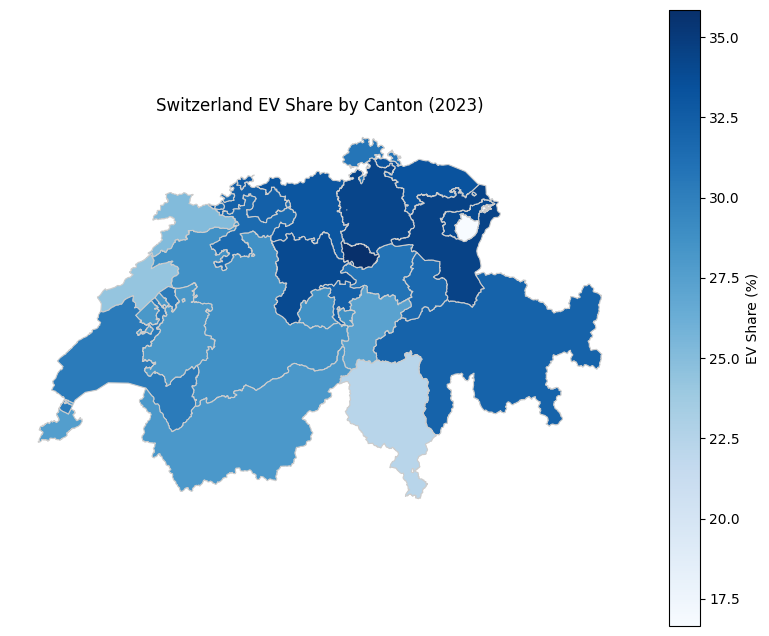

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf.plot(
    column='EV_share',
    cmap='Blues',
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': "EV Share (%)"}
)
ax.set_title(f'Switzerland EV Share by Canton ({latest_year})')
ax.axis('off')
plt.show()

In [18]:
latest_year = EV_absolute['date'].max()
ev_abs_latest = EV_absolute[EV_absolute['date'] == latest_year].iloc[0]
ev_abs_dict = {col: int(ev_abs_latest[col]) for col in EV_absolute.columns if col != 'date'}
# Already done:
# gdf['abbr'] = gdf['kan_name'].map(canton_abbr)

gdf['EV_absolute'] = gdf['abbr'].map(ev_abs_dict)

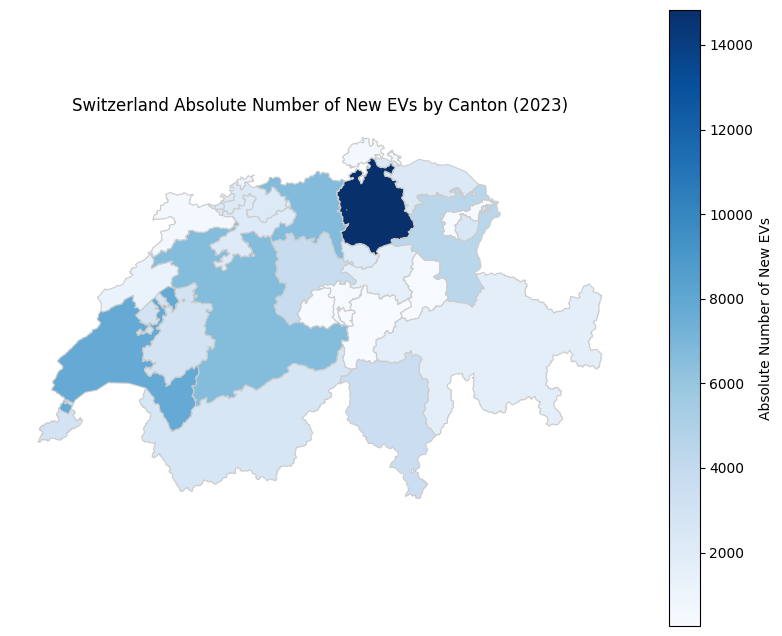

In [19]:

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf.plot(
    column='EV_absolute',
    cmap='Blues',
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': "Absolute Number of New EVs"}
)
ax.set_title(f'Switzerland Absolute Number of New EVs by Canton ({latest_year})')
ax.axis('off')
plt.show()
